### OTT Analysis and Movie/TV show recommender

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
df = pd.read_csv('OTT_dataset_test.csv')    # reading the dataset
df.shape

(8807, 12)

8807 rows with 12 features

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


Most features are categorical, there is one numerical variable, Release year. This feature is more nominal than quantitative

In [91]:
df.drop('show_id',axis=1,inplace = True)       # dropping this feature as ID does not provide any important information

#### Handling Missing values

In [92]:
df.isnull().sum()

type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64

There are a lot of missing values. As we have seen, all but 1 column is categorical. Will analyse the frequency of each category for the features having null

#### 1. Null values in Rating

In [93]:
print(len(df.rating.unique()))
df.rating.value_counts()

18


rating
TV-MA       3207
TV-14       2160
TV-PG        863
R            799
PG-13        490
TV-Y7        334
TV-Y         307
PG           287
TV-G         220
NR            80
G             41
TV-Y7-FV       6
NC-17          3
UR             3
74 min         1
84 min         1
66 min         1
Name: count, dtype: int64

There are some cateogries which don't fall under the usual ratings [74 min, 84min, 66min]. Replacing them with UR

NR and UR are termed as Notrated or Unrated.


In [94]:
df.rating.fillna('UR',inplace = True)       # Filling missing values of rating with UnRated category (UR)

df.rating.replace({ '74 min':'UR',               # replacing categories to Unrated
                    'NR':'UR',
                    '84 min':'UR',
                    '66 min':'UR'},inplace = True)

print('Number of categories have reduced to ',len(df.rating.unique()))
df[df.rating.isnull() == True]          # no missing values

Number of categories have reduced to  13


,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description


#### 2. Null values in Duration

In [95]:
df[df.duration.isnull() == True]          

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
5541,Movie,Louis C.K. 2017,Louis C.K.,Louis C.K.,United States,"April 4, 2017",2017,UR,NaN,Movies,"Louis C.K. muses on religion, eternal love, gi..."
5794,Movie,Louis C.K.: Hilarious,Louis C.K.,Louis C.K.,United States,"September 16, 2016",2010,UR,NaN,Movies,Emmy-winning comedy writer Louis C.K. brings h...
5813,Movie,Louis C.K.: Live at the Comedy Store,Louis C.K.,Louis C.K.,United States,"August 15, 2016",2015,UR,NaN,Movies,The comic puts his trademark hilarious/thought...


The 3 missing values for Duration is for movie type. There are only 3 rows so, filling this with the Mode for all Movies

In [96]:
df[df.type == 'Movie'].duration.value_counts()

duration
90 min     152
94 min     146
93 min     146
97 min     146
91 min     144
          ... 
212 min      1
8 min        1
186 min      1
193 min      1
191 min      1
Name: count, Length: 205, dtype: int64

In [97]:
df.duration.fillna('90 min',inplace = True)

#### 3. Null values in Date added

In [98]:
df.date_added.value_counts()

date_added
January 1, 2020      109
November 1, 2019      89
March 1, 2018         75
December 31, 2019     74
October 1, 2018       71
                    ... 
December 4, 2016       1
November 21, 2016      1
November 19, 2016      1
November 17, 2016      1
January 11, 2020       1
Name: count, Length: 1767, dtype: int64

In [99]:
df = df[df.date_added.isnull() != True]      # as there are only 10 missing values. Dropping these rows
df.reset_index(inplace = True,drop=True) 

#### Feature Engineering on DateAdded

In [100]:
df['yearadded'] = df.date_added.apply(lambda x: x.split(',')[1])     # taking the year of the date the movie/show was added to OTT
df['monthadded'] = df.date_added.apply(lambda x: x.split(',')[0].strip().split(' ')[0])    # taking the month of the date the movie/show was added to OTT
df.drop('date_added',axis=1,inplace = True)          # dropping this feature


In [101]:
# structuring columns
df.insert(6,'year_added',df['yearadded'])
df.insert(7,'month_added',df['monthadded'])
df.drop(['yearadded','monthadded'],axis=1,inplace = True)

In [102]:
df.isnull().sum()

type               0
title              0
director        2624
cast             825
country          830
release_year       0
year_added         0
month_added        0
rating             0
duration           0
listed_in          0
description        0
dtype: int64

#### 4. Null values for country

There are 830 missing values in the feature. The number of Movies and TV shows in this dataset is from United States. So, there is a high chance that the records having missing values would also be from United States 

In [103]:
df.country.fillna('United States',inplace = True)

#### 5. Null Values in Director and Cast

In [104]:
df.fillna('unknown',inplace = True)

In [105]:
df.isnull().sum().sum()             # No missing values

0

### Feature Engineering of Duration

All movies have a duration given in mins. Taking this as a separate feature and filling the missing values as 0

In [106]:
df['Movies_duration(min)'] = df[df.type == 'Movie'].duration.apply(lambda i:i.split(' ')[0])
df.insert(10,'MovieDuration_min',df['Movies_duration(min)'])
df.MovieDuration_min.fillna(0,inplace = True)                 # these values are for shows
df.drop('Movies_duration(min)',axis=1,inplace = True)

Similarly, doing this for TV shows

In [107]:
df['temp'] = df[df.type == 'TV Show'].duration.apply(lambda j: j.split(' ')[0])
df.insert(11,'TV_Duration_season',df['temp'])
df.drop('temp',axis=1,inplace = True)
df.TV_Duration_season.fillna(0,inplace = True)                 # these values are for shows


In [108]:
df.drop('duration',axis=1,inplace = True)      # dropping this feature post FE

#### Feature Engineering of Country

There are many unique values of Feature country in the data. Finding the presence of each unique category with respect to all records.

Replacing countries that are present in less than 1% of records

In [109]:
df.country.replace('United States, United Kingdom','United Kingdom, United States',inplace=True)
df.country.replace('United Kingdom, United States','United States',inplace=True)

df.country.replace('United States, Canada','Canada, United States',inplace=True)
df.country.replace('Canada, United States','Canada',inplace=True)

In [110]:
total = df.country.value_counts().sum()
fe_country = pd.DataFrame({
    'Country':df.country.value_counts().index,
    'Count':df.country.value_counts().values,
    'Percentage':df.country.value_counts()*100/total}).reset_index(drop=True)


# Countries present in more than 1% of the records
countries = fe_country[fe_country.Percentage > 1].Country.values.tolist()

df['Country'] = [country if country in countries else 'others' for country in df.country]

In [111]:
# # This percentage of records will have the original country values
# Remaining data points will have country = 'others'
fe_country[fe_country.Percentage > 1].Percentage.sum()

74.80959417983405

In [112]:
df.Country.value_counts()

Country
United States     3764
others            2216
India              972
United Kingdom     418
Canada             299
Japan              244
South Korea        199
Spain              145
France             124
Mexico             110
Egypt              106
Turkey             105
Nigeria             95
Name: count, dtype: int64

#### Exploratory Data Analysis

#### 1. Visualizing the type of entertainment

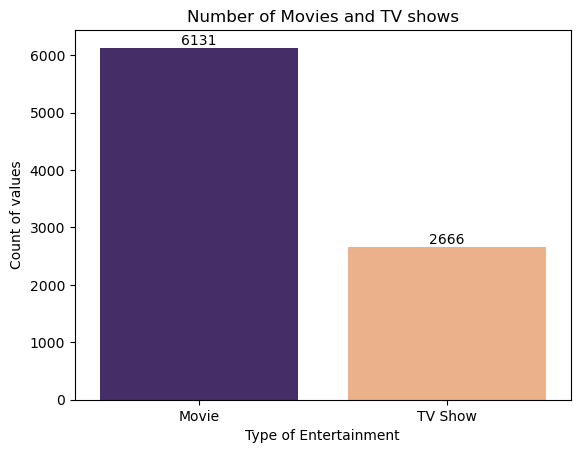

In [113]:
plt.title('Number of Movies and TV shows')

ax=sns.countplot(df,x='type',palette=['#432371',"#FAAE7B"])    # count of records in each type of entertainment
plt.ylabel('Count of values')
plt.xlabel('Type of Entertainment')

for label in ax.containers:       # displays the labels for each bar
    ax.bar_label(label)
plt.show()


There are more unique movies streaming on OTT sites than TV shows.

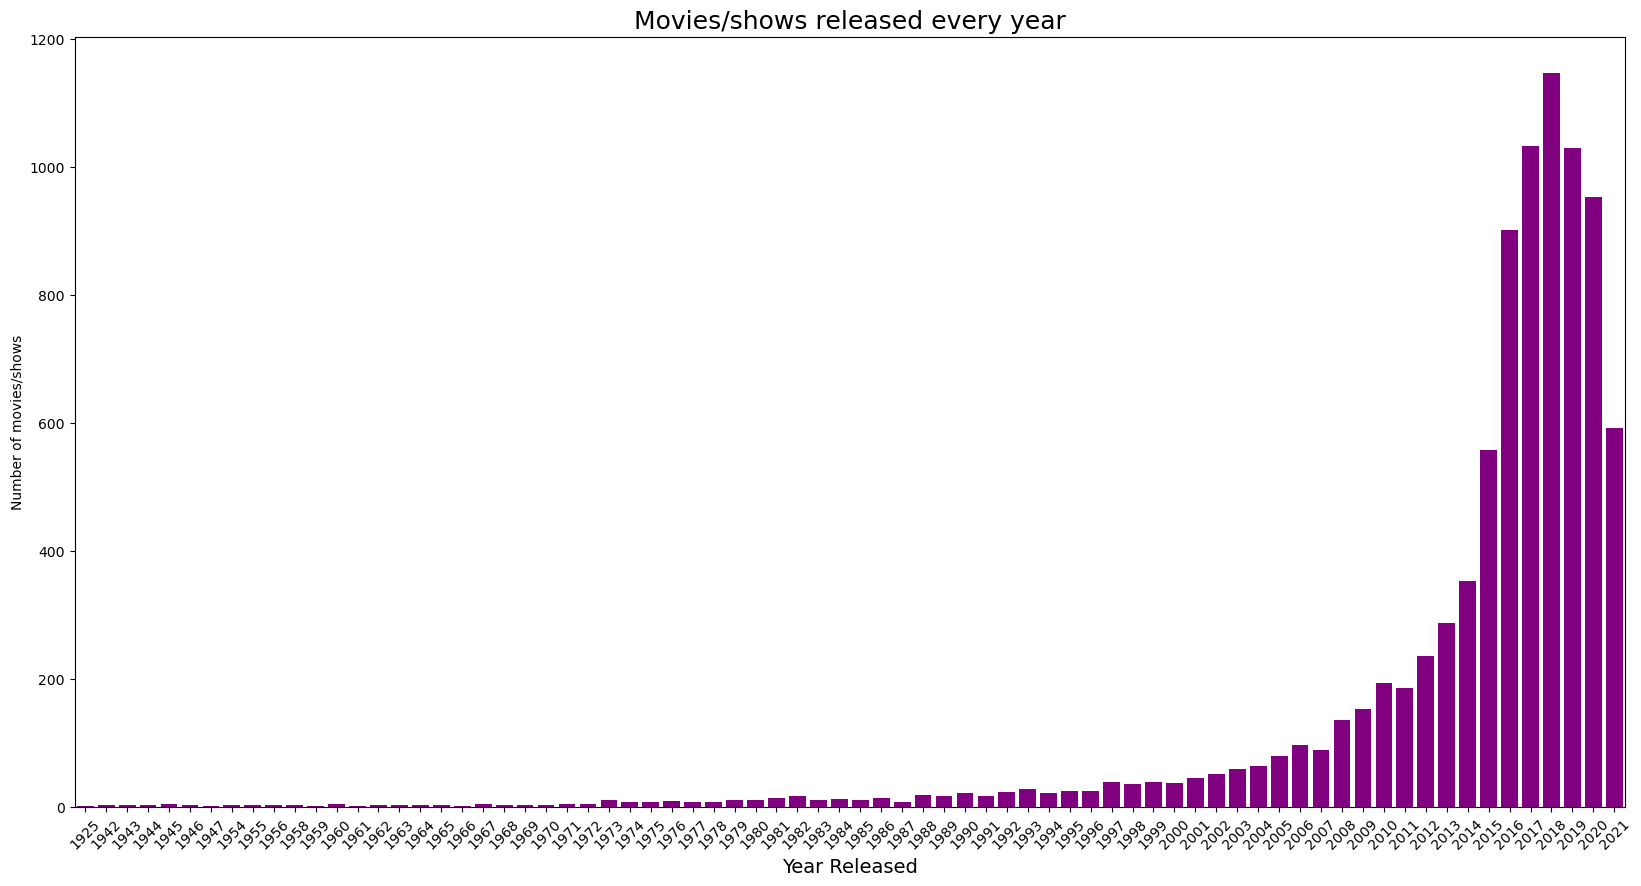

In [114]:
plt.figure(figsize=(20,10))
plt.title('Movies/shows released every year',fontsize=18)
ax = sns.countplot(df,x='release_year',saturation=5.5,color='purple')    # number of movies released for each year
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)          # rotates the xaxis labels by 45 degrees
plt.xlabel('Year Released',fontsize=14)
plt.ylabel('Number of movies/shows')
plt.show()

1. There is an exponential increase in the number of movies/shows released every year. As technology improved with time and the world moved more digital and smaller (with remote working now in the picture), the steep increase in movies and shows being released matches the increasing demand for them.

2. The earliest release was in the year 1925. This TV show as seen below was only added to OTT in 2018

3. 2018 had the highest number of movies and shows released. It peaked at this year and then after that we can see a drop in the year 2019, 2020 and 2021. This could be due to COVID. The production of the entertainment industry dropped in these years.

4. 2021 had a lot less movies & shows released. This could be due to the pandemic as mentioned or it is also possible that we have data missing. 

We have seen the overall trend in movies & TV shows together. Let's analyze if the trend follows for them separately


In [115]:
df[df.release_year == 1925]         # oldest movies on OTT that was added in the year 2018

,type,title,director,cast,country,release_year,year_added,month_added,rating,MovieDuration_min,TV_Duration_season,listed_in,description,Country
4250,TV Show,Pioneers: First Women Filmmakers*,unknown,unknown,United States,1925,2018,December,TV-14,0,1,TV Shows,This collection restores films from women who ...,United States


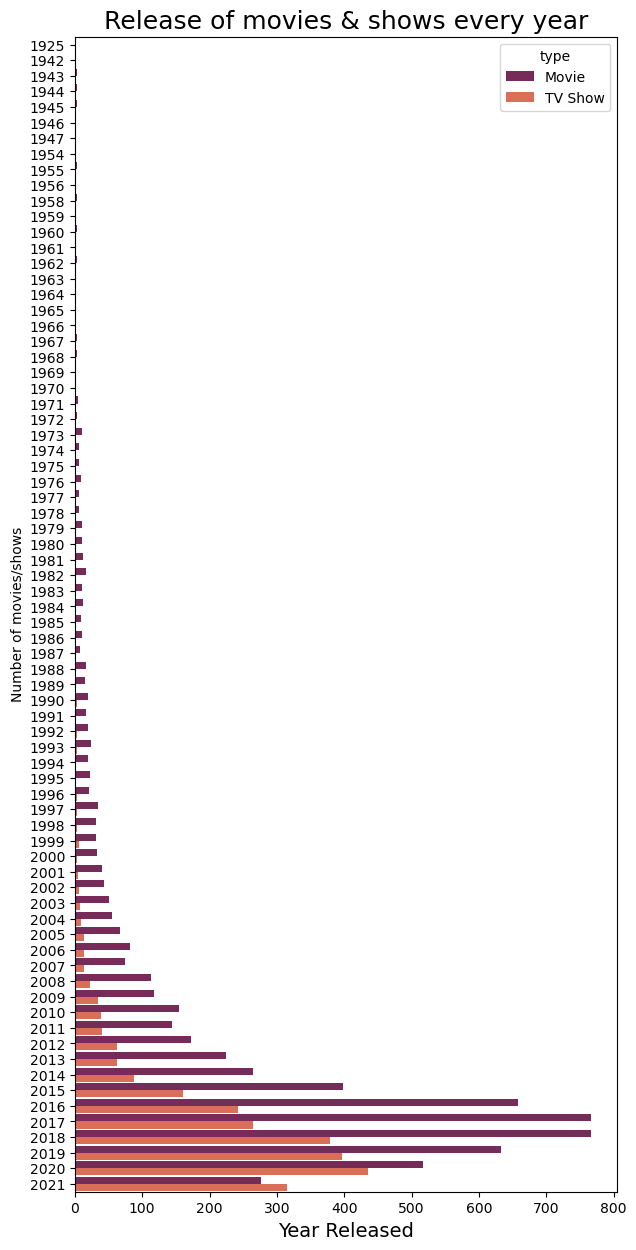

In [116]:
plt.figure(figsize=(7,15))
plt.title('Release of movies & shows every year',fontsize=18)
ax = sns.countplot(df,y='release_year',hue='type',palette='rocket',width=0.9) # adds a color distinction for each Movie and TV show
# ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.xlabel('Year Released',fontsize=14)
plt.ylabel('Number of movies/shows')
plt.show()

1. The trend followed is the same for movies and shows.

2. As the number of movies in the dataset is more than shows, the number released each year is also more. This is seen for every year other than 2021. The reason for this could be incomplete dataset or increasing demand for TV shows by OTT customers.

3. In the 1970s, movies and shows started getting produced

4. Production and release of TV shows started picking up only in early 2000s

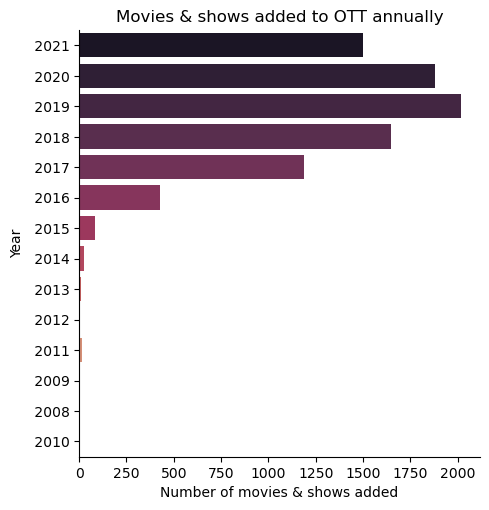

In [117]:
sns.catplot(data=df,y='year_added',kind='count',palette='rocket',saturation=0.6)     # number of movies and shows added for every year in the last 15 years
plt.xlabel('Number of movies & shows added')
plt.title('Movies & shows added to OTT annually')

plt.ylabel('Year')
plt.show()

1. Before 2014, there were very few movies & shows being added to OTT

2. The selection on OTT sites started picking up only from 2015

3. The numbers reached the maximum in 2019 and 2020. These 2 years, had a large number of the population stuck at home because of the pandemic causing an increase in the demand of home based entertainment options. OTT channels were at their highest popularity

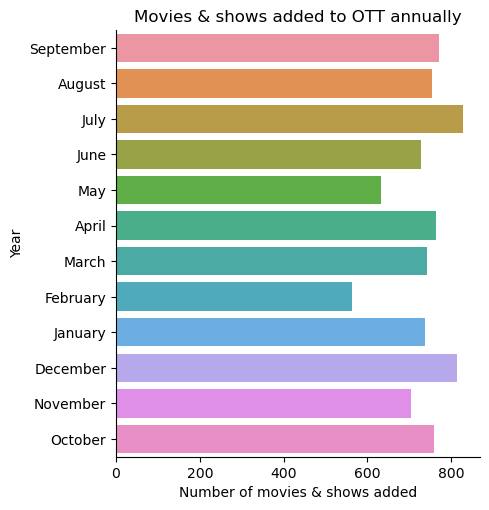

In [118]:
sns.catplot(data=df,y='month_added',kind='count')      # number of movies added to OTT for each month of the annual year
plt.xlabel('Number of movies & shows added') 
plt.title('Movies & shows added to OTT annually')

plt.ylabel('Year')
plt.show()

There is no trend in which month a movie/show is added to OTT channels. The month a movie/show is added to OTT doesn't depend on the time of the year.

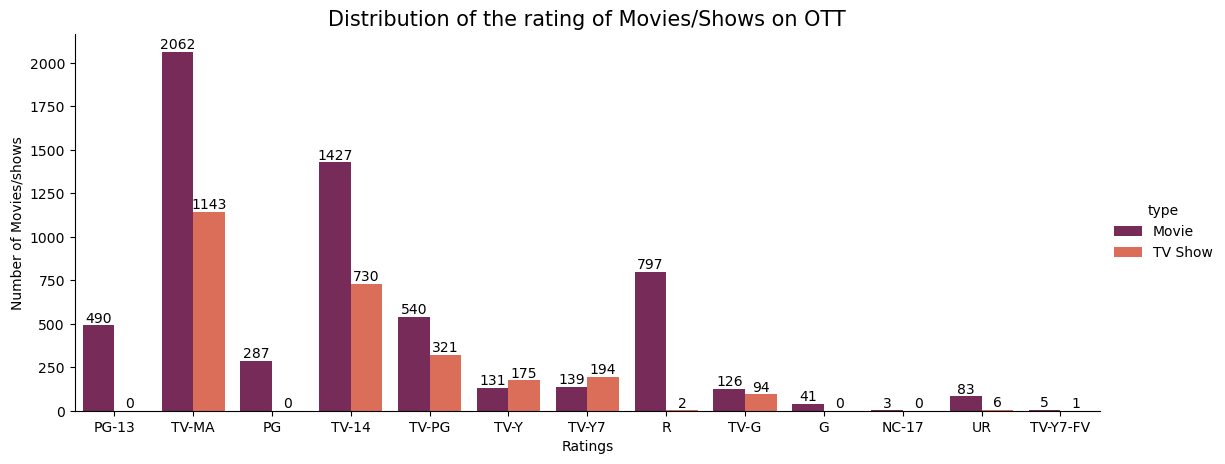

In [119]:
ax = sns.catplot(df,x='rating',kind='count',height=4.5,aspect=2.5,palette='rocket',hue='type')  # displays the movies & shows distinctly with the rating provided
axs = ax.facet_axis(0,0)
for label in axs.containers:     # labels each bar using catplot is slightly different code to countplot
    labels = label
    axs.bar_label(labels)
plt.title('Distribution of the rating of Movies/Shows on OTT',fontsize=15)
plt.xlabel('Ratings')
plt.ylabel('Number of Movies/shows')
plt.show()

1. Most movies and shows are rated as 'TV-MA' or Mature Audiences. Mojority of the entertainment on OTT sites are not for those below 18

2. Almost all TV shows on OTT are for mature audiences. Kids and younger adults looking for entertainment would require parental guidance

3. Movies on the other hand are for younger audiences as well

4. Overall, the types of movies and shows present on OTT are not uniformly distributed for all audiences. Not everyone can watch everything


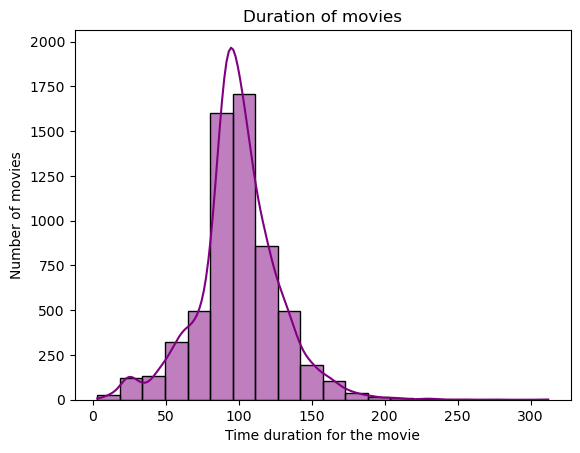

In [120]:
df.MovieDuration_min = df.MovieDuration_min.astype('int')
sns.histplot(data = df[df.MovieDuration_min != 0],
            x = 'MovieDuration_min',
            bins=20,
            kde=True,
            fill=True,
            color='purple')    # distribution of the duration of only Movies in the dataset
plt.title('Duration of movies')
plt.ylabel('Number of movies')
plt.xlabel('Time duration for the movie')
plt.show()

1. The distribution of movie duration is normal

2. Most movies are 100 mins long

3. The number of very long and short movies are less. Bell curved characteristics

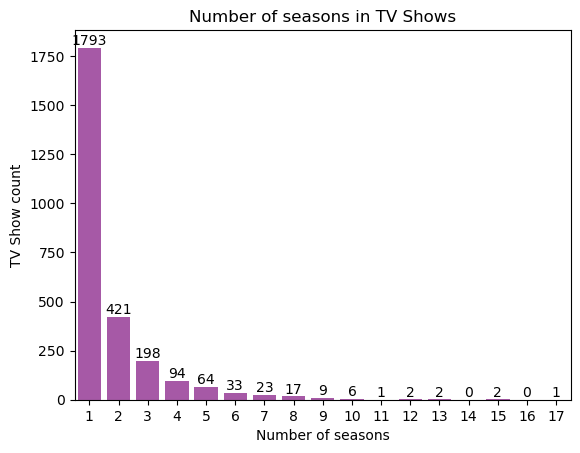

In [121]:
ax = sns.countplot(data = df[df.TV_Duration_season != 0],
            x = 'TV_Duration_season',
            color='magenta',
            saturation=0.3,
            order = [str(num) for num in range(1,18)])    # distribution of the duration of only Movies in the dataset

for label in ax.containers: ax.bar_label(label)
    
plt.title('Number of seasons in TV Shows')
plt.ylabel('TV Show count')
plt.xlabel('Number of seasons')
plt.show()

1. Most TV shows don't run for long. They stop production after 1 season itself.

2. People have a shorter attention span or they loose interest in continuing shows. 

3. As shows run for a long time (more seasons), people don't have time to continue watching. This reduces the demand for that show, leading to the production stopping.

4. There are very few TV shows that have long running times. These shows have a very strong viewer base and must be very interesting

5. Other than reducing demand being a reason for shows having shorter running times, more options to choose from is a very important factor. People have a lot more similar TV shows to choose from. Higher competition could be causing above trend

## Popularity Based Recommender: Top TV shows having 10 or more seasons

In [122]:
df[df.TV_Duration_season.isin([str(val) for val in range(10,18)])].loc[:,['title','TV_Duration_season']].sort_values('TV_Duration_season',ascending=False)

,title,TV_Duration_season
548,Grey's Anatomy,17
2423,Supernatural,15
4798,NCIS,15
1354,Heartland,13
4220,COMEDIANS of the world,13
4964,Trailer Park Boys,12
5412,Criminal Minds,12
6454,Cheers,11
390,The Walking Dead,10
1622,Stargate SG-1,10


Most of the TV shows seen here are well known. These shows having a large running time is very well appreciated by the audiences. 

**Top favorite TV show - 'Greys Anatomy'**

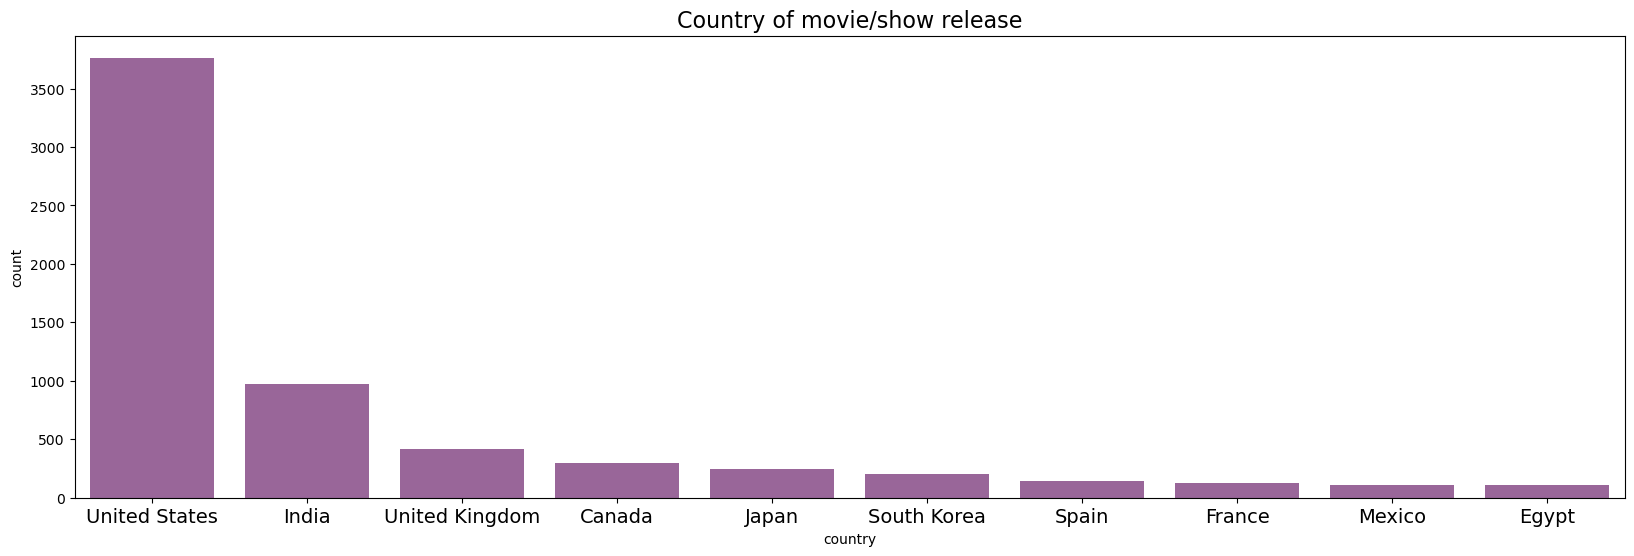

In [123]:
top_categories = df['country'].value_counts().nlargest(10).sort_values(ascending=False).index


plt.figure(figsize = (20,6))
sns.countplot(data=df[df.country.isin(top_categories)] ,
              x = 'country',
              color='magenta',
              saturation=0.2,
              order=list(top_categories))
plt.title('Country of movie/show release',fontsize = 16)
plt.xticks(fontsize=14)
plt.show()

1. Most movies and TV shows are present on OTT are from US and India

2. OTT contains a majority of hollywood content. This could be because most of the streaming channels are US companies

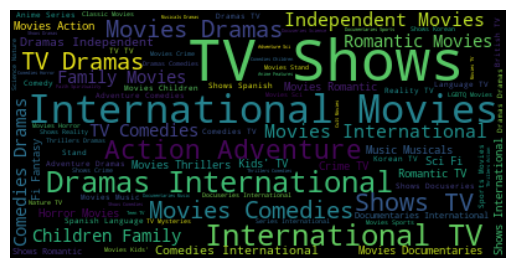

In [124]:
import wordcloud
from wordcloud import WordCloud

text = ','.join([item.strip() for item in ','.join(df.listed_in.values.tolist()).split(',')])

wc = WordCloud().generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

1. Most of the movies & shows in the data are international

2. Dramas, Action and adventure movies and shows are mostly present in the data

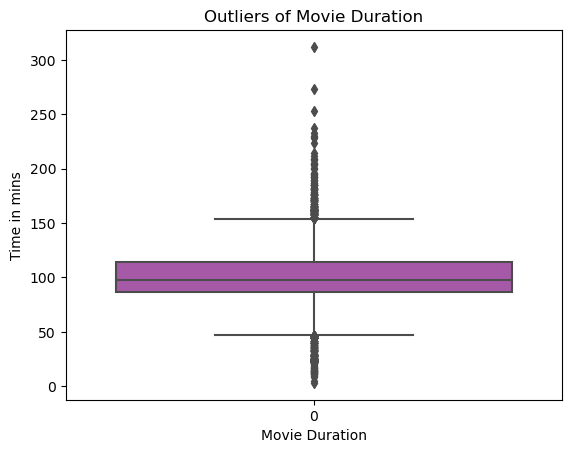

In [125]:
sns.boxplot(df[df.MovieDuration_min != 0].MovieDuration_min,color='magenta',saturation=0.3)
plt.title('Outliers of Movie Duration')
plt.ylabel('Time in mins')
plt.xlabel('Movie Duration')
plt.show()

1. Most of the movies are centered around the median. Most movies have similar running times

2. There are a lot of movies that have large and shorter running times than ususal

### Content Based Recommender System

#### Feature Engineering of 'Listed_in'

In [126]:
df.listed_in.value_counts()

listed_in
Dramas, International Movies                                   362
Documentaries                                                  359
Stand-Up Comedy                                                334
Comedies, Dramas, International Movies                         274
Dramas, Independent Movies, International Movies               252
                                                              ... 
Crime TV Shows, International TV Shows, TV Sci-Fi & Fantasy      1
International TV Shows, TV Horror, TV Sci-Fi & Fantasy           1
Crime TV Shows, Kids' TV                                         1
Horror Movies, International Movies, Sci-Fi & Fantasy            1
Cult Movies, Dramas, Thrillers                                   1
Name: count, Length: 513, dtype: int64

This feature could be interpreted as the genres of the TV Show or the Movie

In [127]:
genres = df.listed_in.str.split(',',expand=True)
genres.isnull().sum()

0       0
1    2017
2    5071
dtype: int64

There are around 8000 rows in the data. The first column all have a genre. The 2nd column has 2000 rows not having a genre. While the 3rd column has 5000 rows with missing genres. Taking the first 2 columns as the genre for this dataset

In [128]:
genres=genres.iloc[:,:2].fillna('')
genres.columns = ['Genre_1','Genre_2']
genres

,Genre_1,Genre_2
0,Documentaries,
1,International TV Shows,TV Dramas
2,Crime TV Shows,International TV Shows
3,Docuseries,Reality TV
4,International TV Shows,Romantic TV Shows
...,...,...
8792,Cult Movies,Dramas
8793,Kids' TV,Korean TV Shows
8794,Comedies,Horror Movies
8795,Children & Family Movies,Comedies


In [129]:
df.release_year = df.release_year.astype('object')
data = pd.concat([df,genres],axis=1)
data.drop(['listed_in'],axis=1,inplace = True)

##### Choosing features for Recommender

In [130]:
data.columns

Index(['type', 'title', 'director', 'cast', 'country', 'release_year',
       'year_added', 'month_added', 'rating', 'MovieDuration_min',
       'TV_Duration_season', 'description', 'Country', 'Genre_1', 'Genre_2'],
      dtype='object')

In [131]:
data_rec = data[['type','title','year_added','month_added','release_year','rating','MovieDuration_min','TV_Duration_season', 'Genre_1', 'Genre_2']]

data_rec.set_index('title',inplace = True)

In [132]:
data_rec.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8797 entries, Dick Johnson Is Dead to Zubaan
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   type                8797 non-null   object
 1   year_added          8797 non-null   object
 2   month_added         8797 non-null   object
 3   release_year        8797 non-null   object
 4   rating              8797 non-null   object
 5   MovieDuration_min   8797 non-null   int32 
 6   TV_Duration_season  8797 non-null   object
 7   Genre_1             8797 non-null   object
 8   Genre_2             8797 non-null   object
dtypes: int32(1), object(8)
memory usage: 652.9+ KB


In [133]:
data_rec_enc = pd.get_dummies(data_rec)
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors()
knn.fit(data_rec_enc)

NearestNeighbors()

In [134]:
title = "Shutter Island"
dist,ind = knn.kneighbors(data_rec_enc[data_rec_enc.index == title].values.reshape(1,-1),n_neighbors=10)


c:\Users\ArshiaAchar\anaconda3\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


##### Top recommendations for above input

In [135]:
df.iloc[ind[0].tolist()].loc[:,['type','title','country','year_added','month_added','release_year','rating','MovieDuration_min','TV_Duration_season']].reset_index(drop=True)

,type,title,country,year_added,month_added,release_year,rating,MovieDuration_min,TV_Duration_season
0,Movie,Shutter Island,United States,2021,February,2010,R,139,0
1,Movie,Animals on the Loose: A You vs. Wild Movie,United States,2021,February,2021,TV-PG,139,0
2,Movie,Angels & Demons,"United States, Italy",2020,December,2009,PG-13,139,0
3,Movie,Space Sweepers,South Korea,2021,February,2021,TV-MA,138,0
4,Movie,Den of Thieves,United States,2020,May,2018,R,140,0
5,Movie,Mystic River,"United States, Australia",2021,May,2003,R,138,0
6,Movie,Takizawa Kabuki ZERO 2020 The Movie,United States,2021,August,2020,TV-PG,139,0
7,Movie,The Drug King,South Korea,2019,February,2018,TV-MA,139,0
8,Movie,The Devil All The Time,United States,2020,September,2020,R,139,0
9,Movie,Free State of Jones,United States,2020,October,2016,R,139,0


### Summary:

1. There are more movies than TV shows on OTT sites. People prefer watching shorted duration entertainment like movies rather than commiting to long running TV shows

2. The release of movies and shows have exponentially risen in years. 

3. Every year more movies and released than TV shows

4. Number of movies and shows being added to OTT every year is very high and has been increasing since 2015

5. There is no relation between the month when a movie/show is added to OTT and the number of them added. Movies and shows are added based on other factors and is not seasonal.

6. Most of the movies/ shows in the data are not for children. Mature audiences have a lot of viewing content on OTT

7. Most movies have a running time of around 100 mins. There are very few short films and long running movies

8. TV shows being added to OTT generally don't run past the 1st season. Either these shows have abruptly been stopped in 1 season or the show is completed in 1 season.

9. Popularity Based Recommender is the based on the TV shows that have the longest running time. TV shows having the highest number of seasons are the most in demand and hence are very popular among OTT customers. We can see that Grey's Anatomy is top most popular TV show on OTT

10. US and India have the highest number of movies/ shows added to OTT. Other countries don't produce that much in the enterntainment industry

11. Content Based Recommender is a system that finds common movies and shows based on similar features in the dataset. It considers the different attributes of the data and clusters similar records together. By choosing a certain movie/show we would like a recommendation for, It picks up the input attributes and finds other movies/shows in it's cluster. The top 10 for the input is provided in the example above

<center><h1> END </h1></center>